In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
data=pd.read_csv('dataset/Classification/NLS.txt',header=None,delimiter="\s+",skiprows=1)

In [6]:
print(data.shape)

(2606, 2)


In [7]:
print(data.head())

          0         1
0  7.571705 -8.756260
1 -8.962906  0.459065
2  9.445356 -7.170082
3  0.191872  2.211127
4 -8.807716 -1.548033


In [8]:
data_class1=data.iloc[:1303]
data_class2=data.iloc[1304::]

print(data_class1.shape)
print(data_class1.shape)

(1303, 2)
(1303, 2)


In [9]:
def split_data(data):
    m,n=data.shape
    k=int(0.6*m)
    p=k+int(0.2*m)
    training_data=data.iloc[:k]
    validation_data=data.iloc[k:p]
    test_data=data.iloc[p:m]
    
    return training_data, validation_data, test_data

In [10]:
train1, validation1, test1=split_data(data_class1)
train2, validation2, test2=split_data(data_class2)

In [11]:
print(train1.shape,validation1.shape,test1.shape)
print(train2.shape,validation2.shape,test2.shape)

(781, 2) (260, 2) (262, 2)
(781, 2) (260, 2) (261, 2)


[]

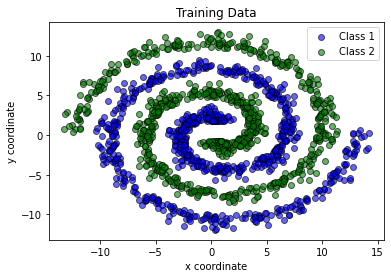

In [12]:
#Plotting training data

plt.scatter(train1[0],train1[1],color='blue',alpha=0.6,label='Class 1', edgecolors="black")
plt.scatter(train2[0],train2[1],color='green',alpha=0.6,label='Class 2', edgecolors="black")
plt.legend()
plt.title("Training Data")
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.plot()

In [13]:
def linear(x):
    return x

def sigmoid(x,fn='logistic'):
    
    if fn=='logistic':
        return 1/(1+np.exp(-x))
    
    elif fn=='tanh':
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [14]:
# Instantaneous error (to be calculated for each pattern)

def instant_error(y,y_pred):
    return (1/2)*sum((y-y_pred)**2)

In [15]:
# Gradient of weights between output layer and hidden layer 1

def output_gradient(y,y_pred,h2,learning_rate=0.01,act_fn='logistic'):
    
    if act_fn=='logistic':
        del_1=(y-y_pred)*y_pred*(1-y_pred)
        return learning_rate*np.outer(h2,del_1),del_1     
    
    elif act_fn=='tanh':
        del_1=(y-y_pred)*(1-(y_pred**2))
        return learning_rate*np.outer(h2,del_1),del_1

In [16]:
# Gradient of weights between input layer and hidden layer 1

def hidden_gradient(w_o,h2,h1,del_1,learning_rate=0.001,act_fn='logistic'):
    
    w_o=w_o[1:,:]           
    if act_fn=='logistic':
        del_2=np.dot(w_o,del_1)*h2*(1-h2)
        return learning_rate*np.outer(h1,del_2),del_2   
    
    elif act_fn=='tanh':
        del_2=np.dot(w_o,del_1)*(1-(h2**2))
        return learning_rate*np.outer(h1,del_2),del_2

In [17]:
def train_network(data,validation,J=4,L=4,learning_rate=0.001,epoch=1000,error_threshold=0.01,hidden_act='logistic',output_act='logistic',track_performance=False,plot_error=True):
    
    m,n=data.shape
    w_h1=np.random.randn(3,J)
    w_h2= np.random.randn(J+1,L)
    w_o=np.random.randn(L+1,2)
    
    error=[]               # list of errors for each pattern in each epoch
    avg_error=[]           # list of average error for each epoch
    avg_e=10**5
    avg_valid_error=[]
    j=1
    while epoch!=0 and avg_e>error_threshold:
        valid_err=[];g1_lst=[];g2_lst=[];s_lst=[]
        for i in range(m):
            x_n=np.array([1,data.iloc[i,0],data.iloc[i,1]])         # concatenating 1 for bias term
            x_n=linear(x_n)                                         # linear activation function at input layer
            
            a_1=np.dot(w_h1.T,x_n)                                   # activation value
            g_1=sigmoid(a_1,hidden_act)                             # activation function at hidden layer 1
            h_1=np.concatenate((np.array([1]),g_1))                 # concatenating 1 for bias term
            g1_lst.append(g_1)

            a_2=np.dot(w_h2.T,h_1)                                   # activation value
            g_2=sigmoid(a_2,hidden_act)                             # activation function at hidden layer 2
            h_2=np.concatenate((np.array([1]),g_2))                 # concatenating 1 for bias term
            g2_lst.append(g_2)

            a_o=np.dot(w_o.T,h_2)                                   # activation value
            s_n=sigmoid(a_o,output_act)                             # activation function at output layer
            s_lst.append(s_n)
            
            # calculate error
            
            if i<int(m/2):
                y_n=[1,0]
            else:
                y_n=[0,1]
                
            e_n=instant_error(np.array(y_n),s_n)
            error.append(e_n)
            
            
            
            # Backpropagation operations
            
            w_o_grad,del1=output_gradient(y_n,s_n,h_2,learning_rate=learning_rate,act_fn=output_act)
            w_o+=w_o_grad
            
            w_h2_grad,del2=hidden_gradient(w_o,g_2,h_1,del1,learning_rate=0.001,act_fn=hidden_act)
            w_h2+=w_h2_grad
            
            w_h1_grad,del3=hidden_gradient(w_h2,g_1,x_n,del2,learning_rate=0.001,act_fn=hidden_act)
            w_h1+=w_h1_grad
        
        # testing model on validation set
        if j==1 or j%10==0:
            y_pred,g1,g2,s=test_model(validation,w_h1,w_h2,w_o,hidden_act=hidden_act,output_act=output_act)
        
            # calculate validation error
            n=len(y_pred)
            for k in range(n): 
                if k<int(n/2):
                    y_k=[1,0]
                else:
                    y_k=[0,1]
                if y_pred[k]==1:
                    y_p=[1,0]
                else:
                    y_p=[0,1]

                err_k=instant_error(np.array(y_k),np.array(y_p))
                valid_err.append(err_k)                 # validation error after each epoch
        
        avg_e=sum(error)/len(error)                     # average error at each epoch
        avg_error.append(avg_e)
        if j==1 or j%10==0:
            avg_valid_err=sum(valid_err)/len(valid_err)     # average validation error at each epoch
          #  avg_valid_error.append(avg_valid_err)
        
        if track_performance==True:
            if j==1 or j%100==0:
                print("Epoch: ",j,end="\n")
                print("Training error: ",avg_e,'\t')
                print("Validation error: ",avg_valid_err)
                
        j+=1
        epoch-=1

    final_error=avg_e               # final error after convergence
    final_valid_error=avg_valid_err   # final error after convergence
    
    if plot_error==True:
        plt.figure(figsize=(8,6))
        plt.plot(avg_error,label='hidden 1: '+str(J)+'\n hidden 2: '+str(L))
        plt.legend()
        plt.title("Average Error vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Average Error")
        plt.xticks(np.arange(1,len(avg_error),500))
        plt.show()
        
    return w_h1,w_h2,w_o,avg_error,final_error,final_valid_error,J,L,np.array(g1_lst).T,np.array(g2_lst).T,np.array(s_lst).T

In [18]:
def test_model(test,w_h1,w_h2,w_o,hidden_act='logistic',output_act='logistic'):
    
    m,n=test.shape
    y_pred=[]           # predicted label
    g1_lst=[]
    g2_lst=[]
    s_lst=[]
    for i in range(m):
        x_n=np.array([1,test.iloc[i,0],test.iloc[i,1]])
        x_n=linear(x_n)                                         # linear activation function at input layer

        a_1=np.dot(w_h1.T,x_n)                                   # activation value
        g_1=sigmoid(a_1,hidden_act)                             # activation function at hidden layer 1
        h_1=np.concatenate((np.array([1]),g_1))                 # concatenating 1 for bias term
        g1_lst.append(g_1)

        a_2=np.dot(w_h2.T,h_1)                                   # activation value
        g_2=sigmoid(a_2,hidden_act)                             # activation function at hidden layer 2
        h_2=np.concatenate((np.array([1]),g_2))                 # concatenating 1 for bias term
        g2_lst.append(g_2)

        a_o=np.dot(w_o.T,h_2)                                   # activation value
        s_n=sigmoid(a_o,output_act)                             # activation function at output layer
        s_lst.append(s_n)
            
        max_val=np.max(s_n)
        if s_n[0]==max_val:
            y_n=1
        else:
            y_n=2
        
        y_pred.append(y_n)
            
    return y_pred,np.array(g1_lst).T,np.array(g2_lst).T,np.array(s_lst).T

<ipython-input-46-6cd3a6e941e6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train=train1.append(train2,ignore_index=True)
<ipython-input-46-6cd3a6e941e6>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid=validation1.append(validation2,ignore_index=True)


Epoch:  1
Training error:  0.37606058460713865 	
Validation error:  0.5192307692307693
Epoch:  100
Training error:  0.19443280412632433 	
Validation error:  0.34423076923076923
Epoch:  200
Training error:  0.17850557949898263 	
Validation error:  0.34423076923076923
Epoch:  300
Training error:  0.1699386680471485 	
Validation error:  0.3346153846153846
Epoch:  400
Training error:  0.16303174625278824 	
Validation error:  0.34423076923076923
Epoch:  500
Training error:  0.1557820138215146 	
Validation error:  0.3173076923076923
Epoch:  600
Training error:  0.14821602877558626 	
Validation error:  0.3057692307692308
Epoch:  700
Training error:  0.14123402199464682 	
Validation error:  0.3230769230769231
Epoch:  800
Training error:  0.1343508382634956 	
Validation error:  0.3038461538461538
Epoch:  900
Training error:  0.12802073474527026 	
Validation error:  0.31346153846153846
Epoch:  1000
Training error:  0.12221414283220734 	
Validation error:  0.2826923076923077
Epoch:  1100
Training

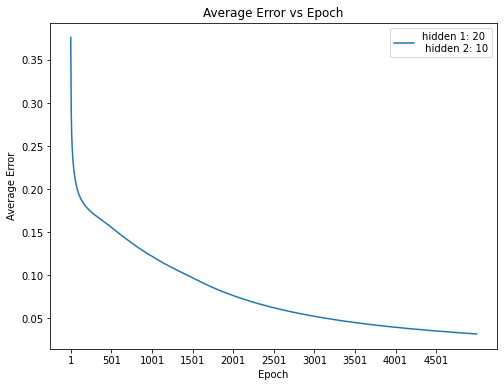

In [46]:
train=train1.append(train2,ignore_index=True)
valid=validation1.append(validation2,ignore_index=True)
w_h1,w_h2,w_out,avg_err,final_err,valid_err,J,L,g1_train,g2_train,s_train=train_network(train,valid,J=20,L=10,learning_rate=0.01,epoch=5000,error_threshold=0.001,hidden_act='tanh',output_act='logistic',track_performance=True,plot_error=True)

In [47]:
x_min=min([min(data_class1.iloc[0]),min(data_class2.iloc[0])])
x_max=max([max(data_class1.iloc[0]),max(data_class2.iloc[0])])
y_min=min([min(data_class1.iloc[1]),min(data_class2.iloc[1])])
y_max=max([max(data_class1.iloc[1]),max(data_class2.iloc[1])])

xx, yy = np.meshgrid(np.arange(x_min-15, x_max+15, 0.1), np.arange(y_min-15, y_max+15, 0.1))
meshgrid=np.c_[xx.ravel(),yy.ravel()]

In [48]:
def decision_region(meshgrid,data1,data2,w_h1,w_h2,w_o,hidden_act='logistic',output_act='logistic'):
    
    c1=[];c2=[]
    
    meshgrid=pd.DataFrame(meshgrid)
    y_pred,g1,g2,s=test_model(meshgrid,w_h1,w_h2,w_o,hidden_act,output_act)
    m,n=meshgrid.shape

    for i in range(m):
        if y_pred[i]==1:
            c1.append((meshgrid.iloc[i,0],meshgrid.iloc[i,1]))
            
        else:
            c2.append((meshgrid.iloc[i,0],meshgrid.iloc[i,1]))
    
    c1=np.array(c1)
    c2=np.array(c2)
    
    J=w_h2.shape[0]-1
    L=w_o.shape[0]-1
    plt.figure(figsize=(8,6))
    plt.scatter(c1[:,0],c1[:,1],color='lightskyblue',label="Region 1")
    plt.scatter(c2[:,0],c2[:,1],color='orange',label="Region 2")
    plt.scatter(data1[0],data1[1],color='blue',edgecolors='black',alpha=0.6,label="Class 1")
    plt.scatter(data2[0],data2[1],color='yellow',edgecolors='black',alpha=0.6,label="Class 2")
    plt.legend(loc="best")
    plt.title('Multi-class decision region.')
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.show()

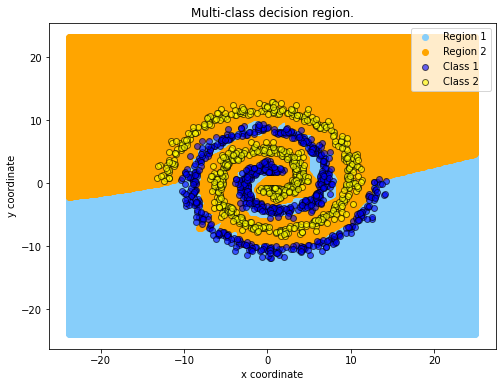

In [49]:
decision_region(meshgrid,train1,train2,w_h1,w_h2,w_out,hidden_act='tanh',output_act='logistic')

In [50]:
# Testing on validation data

valid_pred,g1_valid,g2_valid,s_valid=test_model(valid,w_h1,w_h2,w_out,hidden_act='tanh',output_act='logistic')

# Preparing combined test data

test=test1.append(test2,ignore_index=True)
y_pred,g1_test,g2_test,s_test=test_model(test,w_h1,w_h2,w_out,hidden_act='tanh',output_act='logistic')

<ipython-input-50-e73e436fd980>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test=test1.append(test2,ignore_index=True)


In [51]:
# Confusion Matrix
def confusion_matrix(y_pred):
    mat=np.zeros((2,2))
    n=int(len(y_pred)/2)
    for i in range(len(y_pred)):
        if i<n:                      # true class is 1
            if y_pred[i]==1:
                mat[0][0]+=1
            else:
                mat[1][0]+=1
        else:                        # true class is 2
            if y_pred[i]==1:
                mat[0][1]+=1
            else:
                mat[1][1]+=1
    
    return mat.astype(int)

In [52]:
# Classification accuracy

def accuracy(TP1,TP2,total):
    return ((TP1+TP2)/total)*100

In [53]:
conf_mat_valid=confusion_matrix(valid_pred)
print(conf_mat_valid)

acc_valid=accuracy(conf_mat_valid[0][0],conf_mat_valid[1][1],len(valid_pred))
print("Accuracy of model on validation data: ",acc_valid)

[[243   8]
 [ 17 252]]
Accuracy of model on validation data:  95.1923076923077


In [54]:
conf_mat=confusion_matrix(y_pred)
print("Confusion Matrix for 2-class classification")
print(conf_mat)
acc=accuracy(conf_mat[0][0],conf_mat[1][1],len(y_pred))
print("Accuracy of model: ",acc)

Confusion Matrix for 2-class classification
[[243  10]
 [ 18 252]]
Accuracy of model:  94.64627151051626
